In [2]:
!pip install fredapi

  Obtaining dependency information for fredapi from https://files.pythonhosted.org/packages/73/64/1db43417cf7ed430f104a347126b5260a1724ee9a1b7d0b1622262c9c4df/fredapi-0.5.2-py3-none-any.whl.metadata


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

In [5]:
# Set plot style
plt.style.use('fivethirtyeight')

# Configure Pandas to display more columns in the DataFrame
pd.set_option('display.max_columns', 500)

# Extract color palette from matplotlib
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [6]:
from fredapi import Fred

In [7]:
fred_key = 'e70a93164447369d868e95ac7afeef90'

In [9]:
fred = Fred(api_key=fred_key)

In [11]:
sp_search = fred.search('S&P', order_by='popularity')

In [12]:
sp_search.head()

id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2024-12-02   2024-12-02   
CSUSHPINSA          CSUSHPINSA     2024-12-02   2024-12-02   
SP500                    SP500     2024-12-02   2024-12-02   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2024-12-02   2024-12-02   
BAMLC0A0CM          BAMLC0A0CM     2024-12-02   2024-12-02   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA      S&P CoreLogic Case-Shiller U.S. National Home ...   
SP500                                                     S&P 500   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   
BAMLC0A0CM      ICE BofA US Corporate Index Option-Adjusted Sp...   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2024-11-30  Daily, Close   
CSUSHPINSA            1987-01-01      2024-09-01       Monthly   
SP500                 2014-12-01      2024-11-29  Daily, Close   
BAMLH0A0HYM2EY        1996-12-31      2024-11-30  Daily, Close   
BAMLC0A0CM            1996-12-31      2024-11-30  Daily, Close   

               frequency_short               units         units_short  \
series id                                                                
BAMLH0A0HYM2                 D             Percent                   %   
CSUSHPINSA                   M  Index Jan 2000=100  Index Jan 2000=100   
SP500                        D               Index               Index   
BAMLH0A0HYM2EY               D             Percent                   %   
BAMLC0A0CM                   D             Percent                   %   

                    seasonal_adjustment seasonal_adjustment_short  \
series id                                                           
BAMLH0A0HYM2    Not Seasonally Adjusted                       NSA   
CSUSHPINSA      Not Seasonally Adjusted                       NSA   
SP500           Not Seasonally Adjusted                       NSA   
BAMLH0A0HYM2EY  Not Seasonally Adjusted                       NSA   
BAMLC0A0CM      Not Seasonally Adjusted                       NSA   

                             last_updated popularity  \
series id                                              
BAMLH0A0HYM2    2024-12-02 09:28:09-06:00         92   
CSUSHPINSA      2024-11-26 08:12:02-06:00         88   
SP500           2024-11-29 19:11:37-06:00         83   
BAMLH0A0HYM2EY  2024-12-02 09:28:12-06:00         82   
BAMLC0A0CM      2024-12-02 09:34:03-06:00         78   

                                                            notes  
series id                                                          
BAMLH0A0HYM2    The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA      For more information regarding the index, plea...  
SP500           The observations for the S&P 500 represent the...  
BAMLH0A0HYM2EY  This data represents the effective yield of th...  
BAMLC0A0CM      The ICE BofA Option-Adjusted Spreads (OASs) ar...

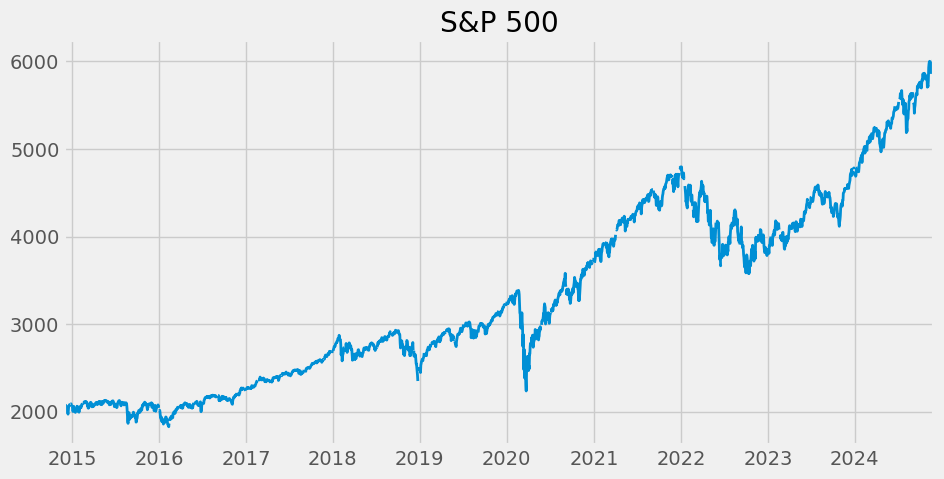

In [13]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

Pull and Join Multiple Data Series

In [14]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [15]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [16]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [17]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [18]:
# Plot States Unemployment Rate
px.line(uemp_states)

Pull October 2024 Unemployment Rate Per State

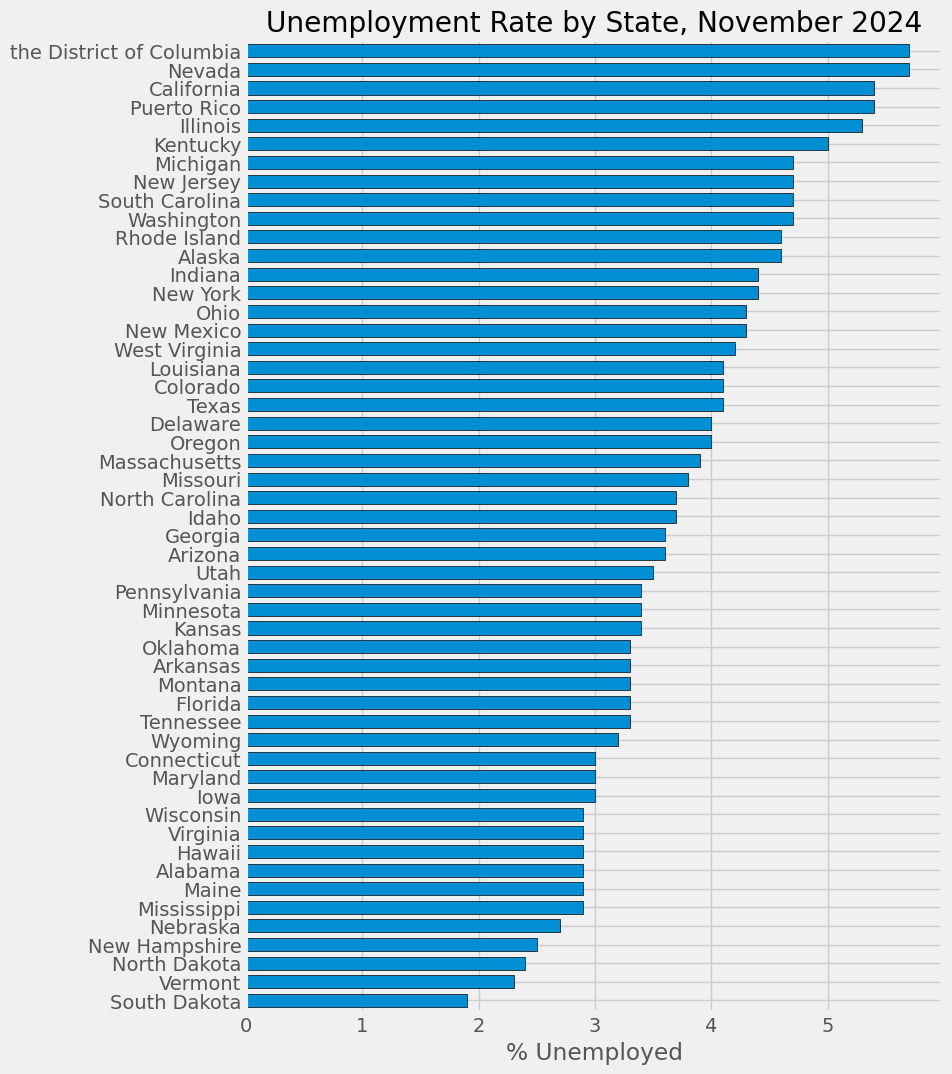

In [25]:
ax = uemp_states.loc[uemp_states.index == '2024-10-01'].T \
    .sort_values('2024-10-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, November 2024')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

Participation Rate

In [26]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [27]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

Plot Unemployment vs Participation for each state!

In [28]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

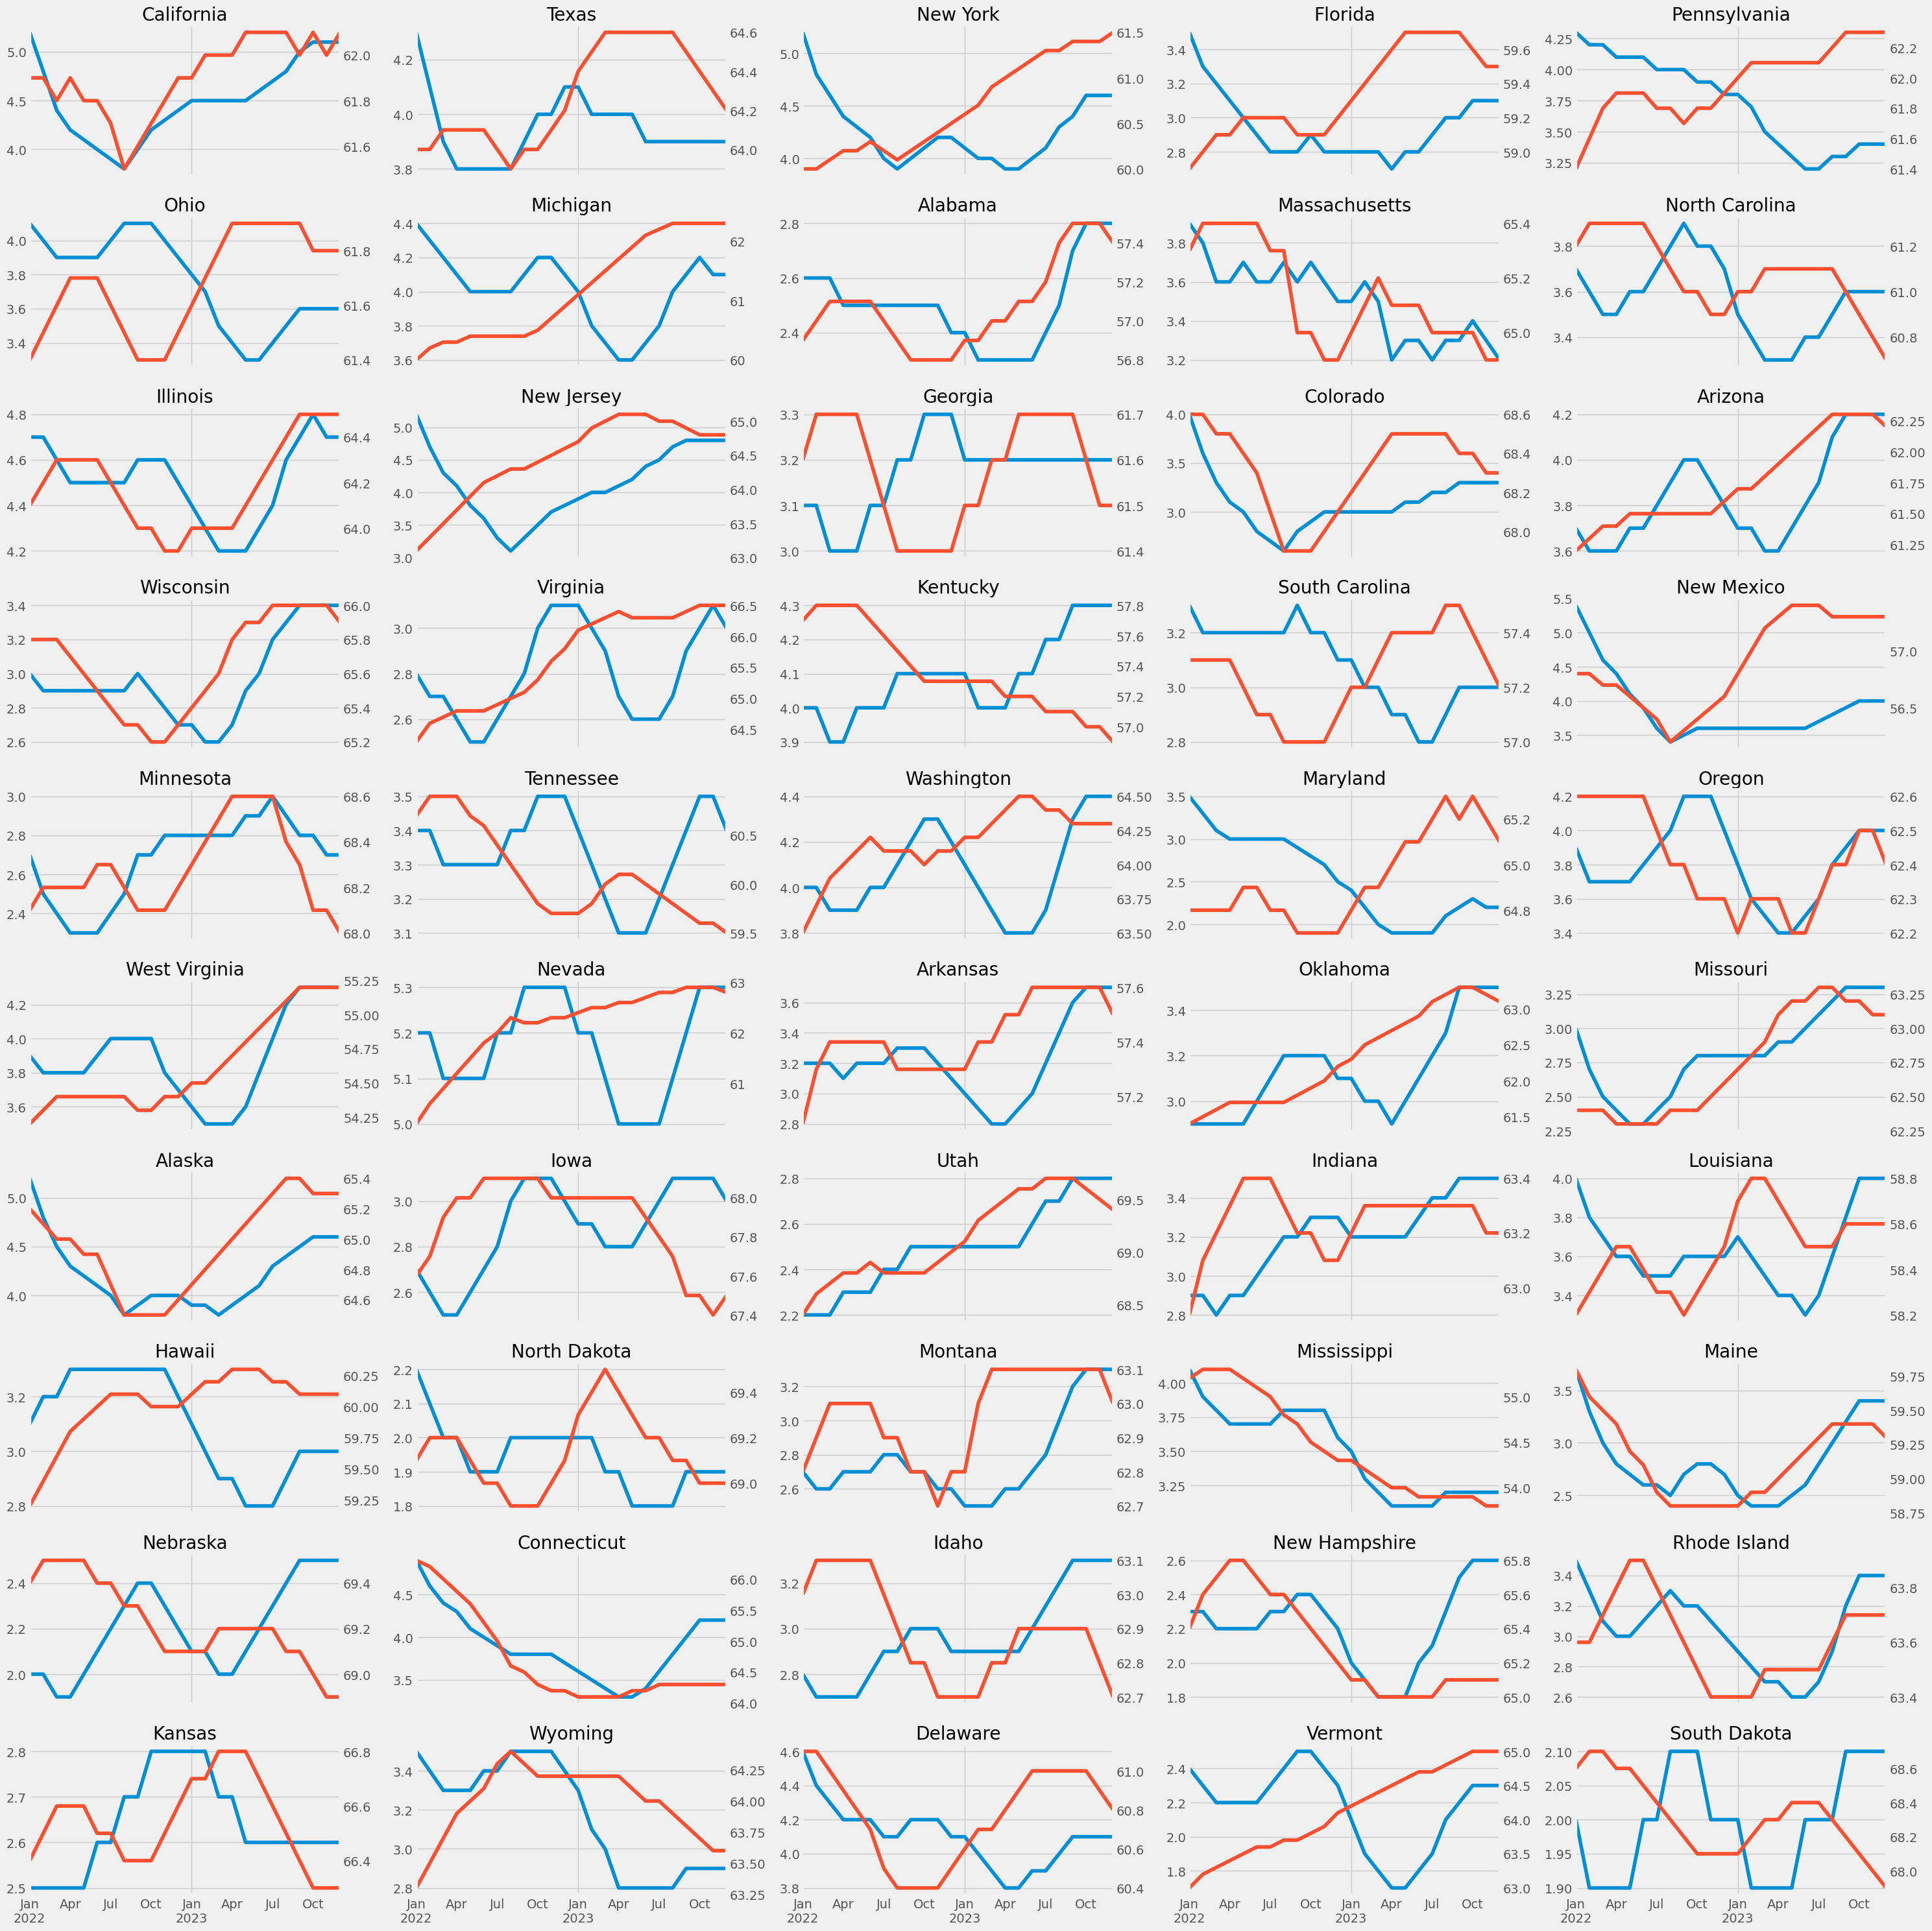

In [29]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2022 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2022 and index < 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

California

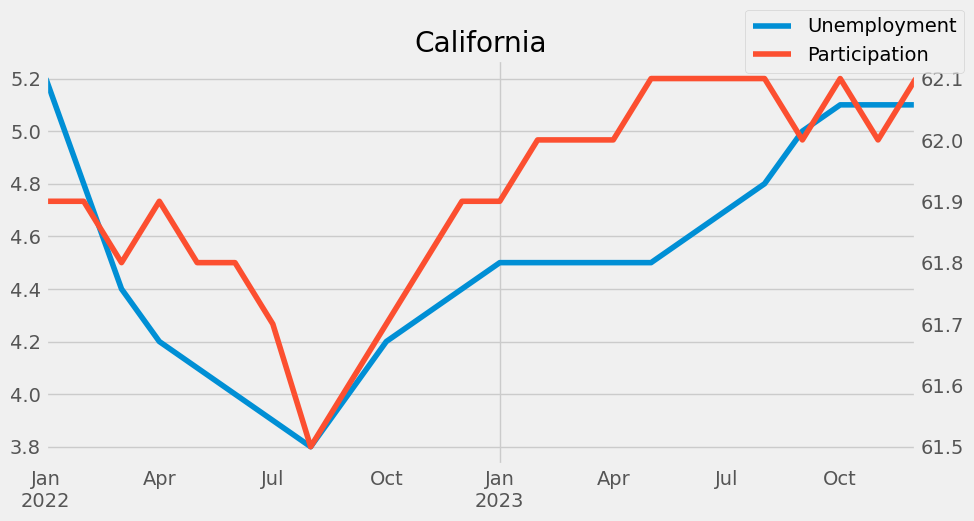

In [30]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2022 and index < 2024')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2022 and index < 2024')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()